In [2]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
notebook_dir = os.path.expanduser('~/Documents/school/MIT/Research/symbolic-nuclr-model')
os.chdir(notebook_dir)

from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
import csv


In [3]:
import glob
locations = glob.glob('models/*')

keys = [l.split('/')[-1] for l in locations]
def cleanup(name):
    if 'long' in name: return 'all'
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}
print(locations)

{'all': 'models/long-run'}


# Explorations

In [4]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds(X, model, data, batch = 200):
    preds = torch.zeros(X.shape[0], 1).to(X.device)
    with torch.no_grad():
        for i in range(0, X.shape[0], batch):
            preds_ = inverse_transform(model(X[i:i+batch]), data)
            preds_ = torch.gather(preds_, 1, X[i:i+batch, [2]])
            preds[i:i+batch] = preds_
    return preds

def get_rms(X, y, model, data):
    preds = get_preds(X, model, data)
    rms = {}
    print(data.output_map)
    for i, task_name in enumerate(data.output_map):
        task_mask = X[:, 2] == i
        rms[task_name] = torch.sqrt(torch.mean((preds[task_mask] - y[task_mask])**2)).item()
    return rms

## Features

In [5]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(IO.load_latest_model(location), map_location=args.DEV))

mask = data.train_mask & ~torch.isnan(data.y[:, 0])
X_train = data.X[mask]
y_train = data.y[mask]

Loading model from models/long-run/ckpts/model.pt


In [6]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

def output_to_rms(output, data, X):
    preds = inverse_transform(output, data)
    preds = preds.gather(1, X[:, 2].long().view(-1, 1))
    return np.sqrt(np.mean((preds.detach().cpu().numpy() - y.detach().cpu().numpy()) ** 2))
    

X = data.X[data.train_mask]
y = data.y[data.train_mask]
mask = lambda x: x[(X[:, 2] == 0) & ~torch.isnan(y.view(-1))]
X, y = mask(X), mask(y)

acts = get_penultimate_acts(model, X)
rms = output_to_rms(model.readout(acts), data, X)
preds = inverse_transform(model.readout(acts), data)
print(f"RMS of readout layer: {rms:.2f}")

RMS of readout layer: 364.08


In [7]:
# linear regression from activations to output to compare with the readout layer
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(acts.detach().cpu().numpy(), y.detach().cpu().numpy())
lr_preds = reg.predict(acts.detach().cpu().numpy())
rms = np.sqrt(np.mean((lr_preds - y.detach().cpu().numpy()) ** 2))
print(f"RMS of linear regression: {rms:.2f}")

RMS of linear regression: 65.41


How is the linear regression prediction so much better?

In [8]:
model_norm = np.linalg.norm(model.readout.weight[0].detach().numpy())
lin_reg_norm = np.linalg.norm(reg.coef_)
print(f"Norm of readout layer: {model_norm:.2f}, norm of linear regression weights: {lin_reg_norm:.2f}")

Norm of readout layer: 3.30, norm of linear regression weights: 3202840.75


In [9]:
n_components = 300
pca = PCA(n_components=n_components)
pca.fit(acts.cpu().numpy())

# project to first n components
ns = np.arange(1, n_components+1)
rms_by_n, rms_ling_alg_by_n = {}, {}
cumm_pcs = []
corrections = []
for n in ns:
    acts_pca = pca.transform(acts.cpu().numpy())
    acts_pca[:, n:] = 0
    acts_ = pca.inverse_transform(acts_pca)
    acts_ = torch.tensor(acts_, device=args.DEV)
    preds = inverse_transform(model.readout(acts_), data)
    preds = preds.gather(1, X[:, 2].long().view(-1, 1))
    if n==1:
        last = preds
        new = preds
    else:
        new = preds - last
        last = preds
    # if n in keep:
    #     saved_pcs.append(new.detach().numpy())
    correction = np.sum(np.abs(new.detach().numpy()))/len(new)
    corrections.append(correction)
corrections = np.array(corrections)
print((-corrections).argsort()[:15])

[ 0  2  1 11  6 12  4 16  7 10 17  5 14 25 43]


In [10]:
keep = np.array((-corrections).argsort()[:15])
keep = keep + 1
saved_pcs = []
for n in ns:
    acts_pca = pca.transform(acts.cpu().numpy())
    acts_pca[:, n:] = 0
    acts_ = pca.inverse_transform(acts_pca)
    acts_ = torch.tensor(acts_, device=args.DEV)
    preds = inverse_transform(model.readout(acts_), data)
    preds = preds.gather(1, X[:, 2].long().view(-1, 1))
    if n==1:
        last = preds
        new = preds
    else:
        new = preds - last
        last = preds
    if n in keep:
        saved_pcs.append(new.detach().numpy())


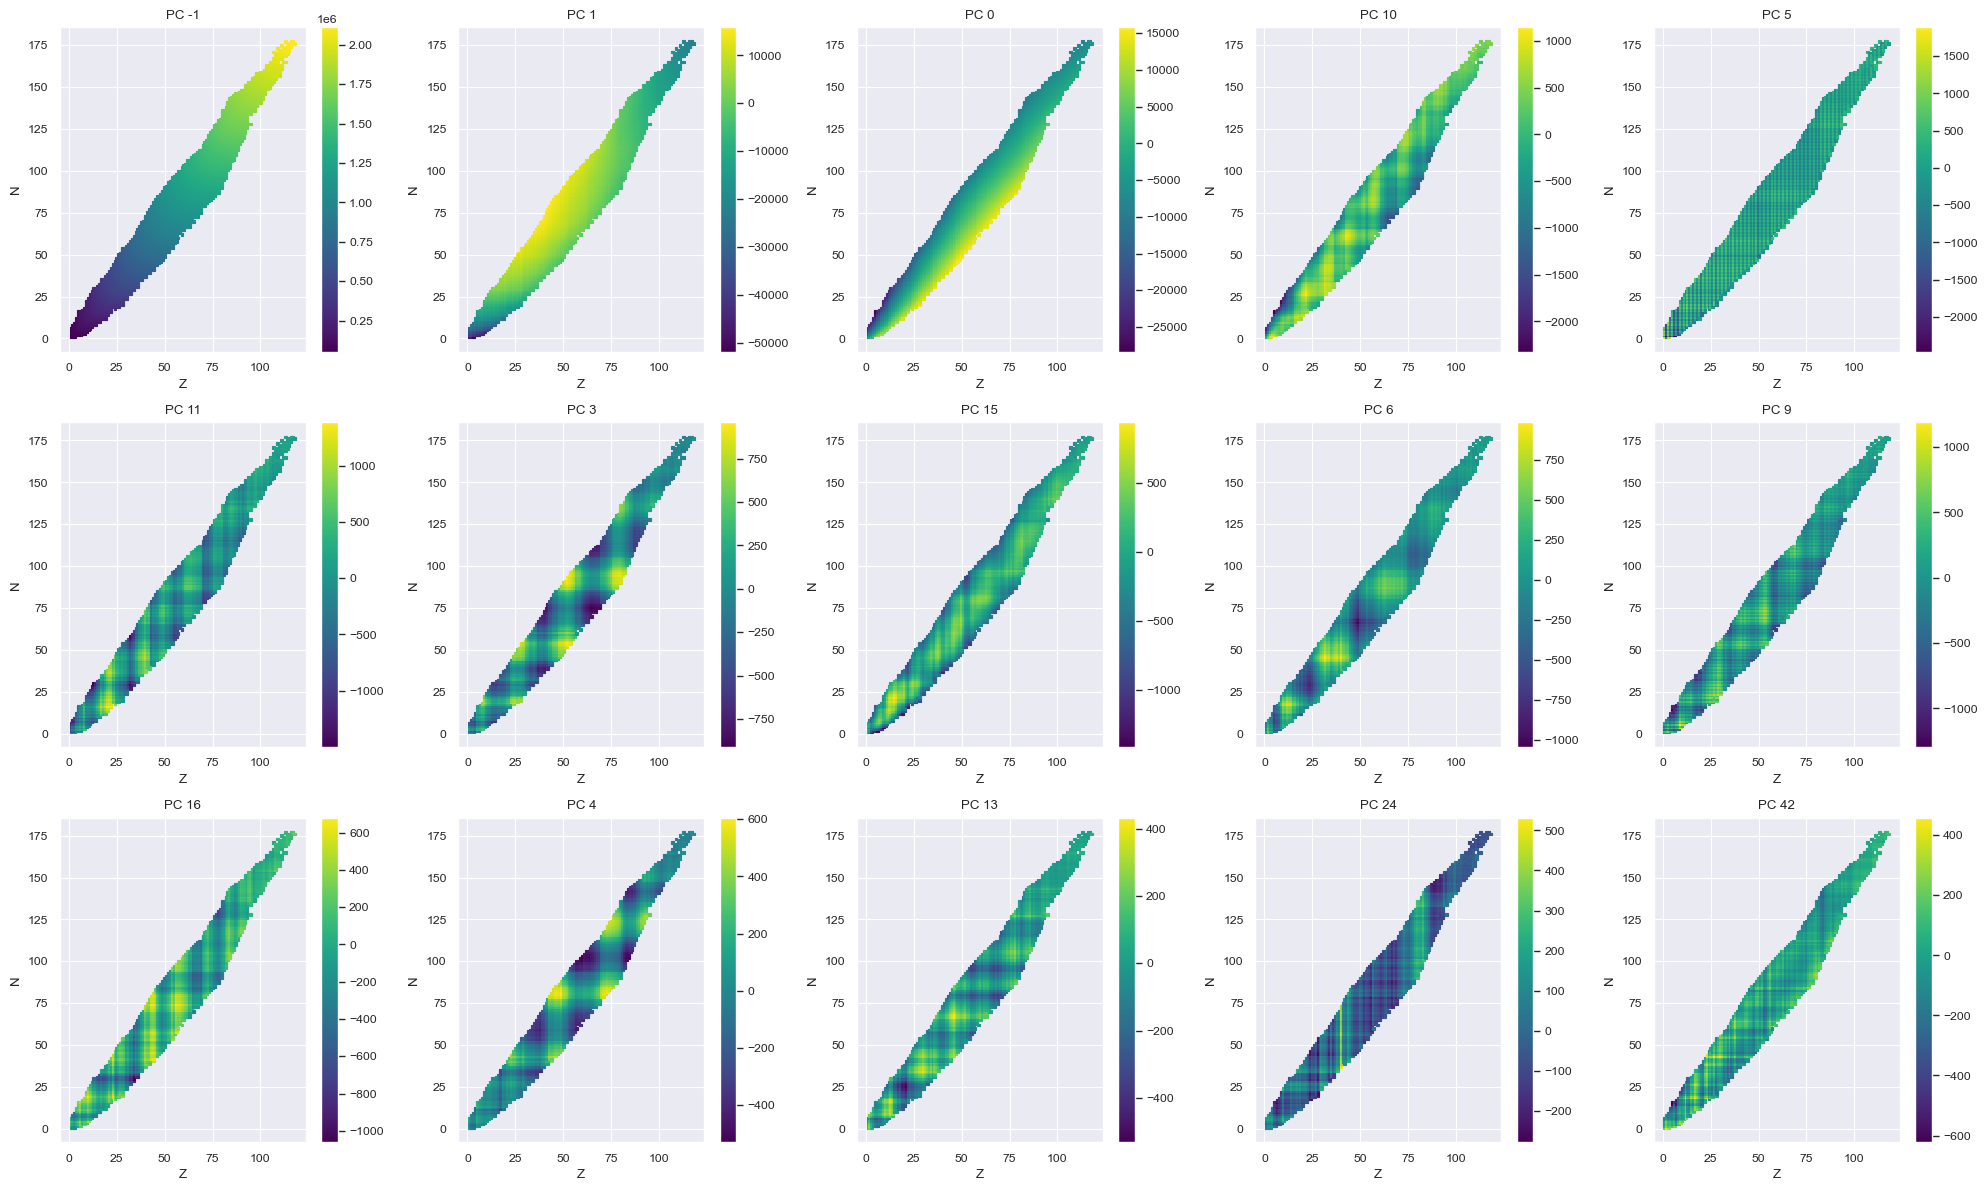

In [13]:
keep = keep - 1
indices = np.argsort(keep)
true_indices = [np.where(keep[indices] == i)[0][0] for i in keep]

Z, N = X[:, :2].detach().cpu().numpy().T

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for i,idx in zip(range(len(axes.flatten())),true_indices):
    ax = axes[i//5, i%5]
    plt.sca(ax)
    plt.scatter(Z, N, c=saved_pcs[idx], cmap="viridis", s=4, marker="s")
    plt.xlabel("Z")
    plt.ylabel("N")
    plt.title(f"PC {keep[i]}")
    plt.colorbar()

fig.tight_layout()
plt.show()


In [12]:
with open('reranked_pcs_with_data.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(Z)
    writer.writerow(N)
    writer.writerow(y.detach().cpu().numpy())
    for i,idx in zip(range(len(axes.flatten())),true_indices):
        writer.writerow(saved_pcs[idx])
